# The Full Encoder
To build the entire encoder, we still need to build the embedding layer and the positional encoding. The input embedding transforms tokens into a sequence of embeddings vectors, while the positional encoding encoding provides positional information (order of the sequence) of each token to the encoder stack.

Below is an illustration of the complete encoder:

![encoder](./photos/Screenshot%20from%202022-09-08%2014-54-50.png)



## Positional Encoding
The positional encoding provides information of the order of the sequences to the encoder. The encoding is defined as follow:
$$PE_{pos, 2i} = sin(\frac{pos}{10000^{\frac{2i}{d_{model}}}})$$
$$PE_{pos, 2i+1} = cos(\frac{pos}{10000^{\frac{2i}{d_{model}}}})$$

Anyone who are curious why the postitional encoding is defined as such should check the [transformer paper](https://arxiv.org/pdf/1706.03762.pdf) or [this article on positional encoding](https://medium.com/swlh/elegant-intuitions-behind-positional-encodings-dc48b4a4a5d1)

Below is an diagram of the positional encoding:

![positional encoding](./photos/Screenshot%20from%202022-09-08%2015-05-10.png)

In [2]:
import torch
from torch import nn

In [3]:
class PositionalEncoding(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        batch_size, seq_len, d_model = x.shape
        
        dims = torch.arange(0, d_model, device=x.device)
        positions = torch.arange(0, seq_len, device=x.device)
        encoding = torch.tensor([[self.pos_encode(d, p, d_model) for d in dims] for p in positions], device=x.device)
        
        return x + encoding

        # x: [batch, seq_len, d_model]
        
    def pos_encode(self, dim, pos, d_model):
        if dim%2==0:
            return torch.sin(pos/(torch.pow(10000, dim/d_model)))
        else:
            return torch.cos(pos/(torch.pow(10000, dim/d_model)))

In [7]:
zeros = torch.zeros((2, 128, 512)) # Zero matrix for generating pure positional encoding: [batch_size, seq_len, d_model]

In [8]:
outputs = PositionalEncoding()(zeros)

In [9]:
outputs.numpy()[0].transpose().shape

(512, 128)

In [10]:
outputs[0].shape

torch.Size([128, 512])

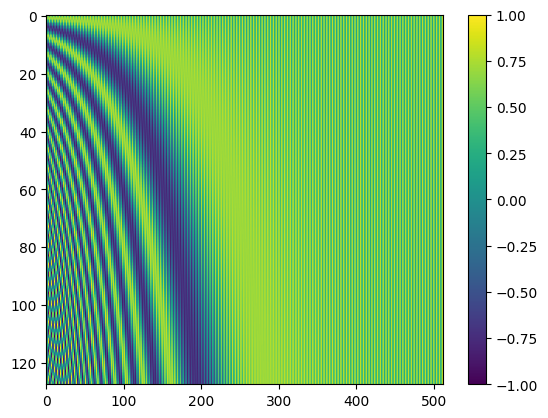

In [11]:
import matplotlib.pyplot as plt
# fig, ax = plt.subplots()

# c = ax.pcolor(outputs.numpy()[0])
# fig.colorbar(c, ax=ax)

im = plt.imshow(outputs.numpy()[0], aspect='auto')
plt.colorbar(im)

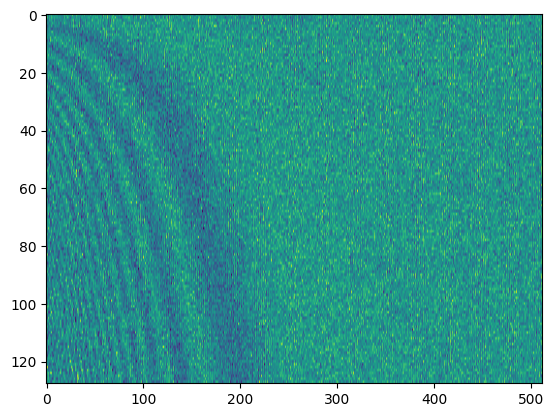

In [12]:
im = plt.imshow(torch.randn((128, 512)).numpy() + outputs.numpy()[0], aspect='auto')

# The final assembly!!
With everything in place, we can finally build the entire encoder! 

In [2]:
from vit.encoder import EncoderStack

import torch
from torch import nn

class PositionalEncoding(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        batch_size, seq_len, d_model = x.shape
        
        dims = torch.arange(0, d_model, device=x.device)
        positions = torch.arange(0, seq_len, device=x.device)
        encoding = torch.tensor([[self.pos_encode(d, p, d_model) for d in dims] for p in positions], device=x.device)
        
        return x + encoding

        # x: [batch, seq_len, d_model]
        
    def pos_encode(self, dim, pos, d_model):
        if dim%2==0:
            return torch.sin(pos/(torch.pow(10000, dim/d_model)))
        else:
            return torch.cos(pos/(torch.pow(10000, dim/d_model)))

class TransformerEncoder(nn.Module):
    def __init__(self, vocab_size, d_model, num_layer, num_head, d_k):
        super().__init__()

        self.vocab_size = vocab_size
        self.d_model = d_model
        self.num_layer = num_layer
        self.num_head = num_head
        self.d_k = d_k

        # An embedding layer that transforms tokens to model embeddings
        # See: https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html
        # [batch_size, seq_len] -> [batch_size, seq_len, d_model]
        self.embedding = nn.Embedding(self.vocab_size, self.d_model)
        self.positional_encoding = PositionalEncoding()
        self.layers = EncoderStack(self.num_layer, self.d_model, self.num_head, self.d_k)

    def forward(self, x):
        # x: [batch_size, seq_len]
        x = self.embedding(x)
        x = self.positional_encoding(x)
        x = self.layers(x)
        return x

Now we write a unit test to make sure gradients are good

In [8]:
def full_encoder_unit_test():
    import torch
    from vit.encoder import TransformerEncoder
    encoder = TransformerEncoder(1000, 512, 6, 8, 64).to('cpu') #[d_model, num_head, d_k]
    dummy_inputs = torch.randint(0, 1000, (2, 128)).to('cpu') #[batch_size, seq_len]
    y = encoder(dummy_inputs)
    loss = y.mean()
    loss.backward()
    for name, param in encoder.named_parameters():
        assert param.grad is not None

In [9]:
full_encoder_unit_test()

Then we visualize the entire encoder using the `torchviz` library

In [12]:
import torch

dummy_inputs = torch.randint(1000, (6, 128)).to(device) # [batch_size, seq_len]
x = dummy_inputs

In [18]:
from vit.encoder import TransformerEncoder

device = 'cpu'

transformer_encoder = TransformerEncoder(
    vocab_size=1000, 
    d_model=512,
    num_layer=6,
    num_head=8,
    d_k=64
).to(device)

In [19]:
from torchviz import make_dot

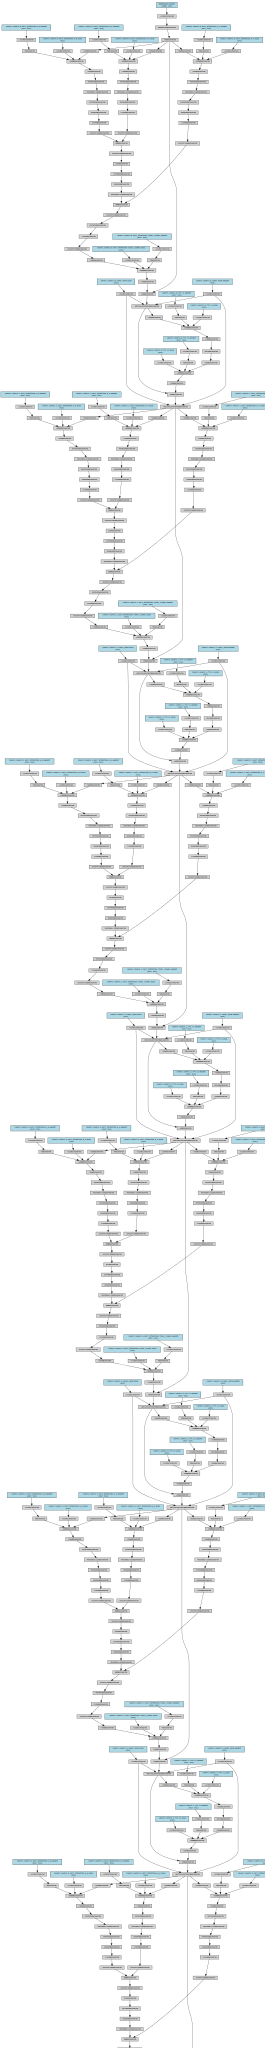

In [20]:
y = transformer_encoder(x)
make_dot(y.mean(), params=dict(transformer_encoder.named_parameters()))

## Dropout and Masking

According to the transformer paper, our encoder model are still missing two things: dropout and masking. We'll implement these two functionalities below.

### Dropout
According to the paper, dropout is applied to the output of each of the sub-layers, the positional encodings, and the sum of the encodings. Applying dropout is trivial so I'll skip it in this notebook. Take a look at the source code if you're interested in the details.

### Masking

Masking, though not required in the encoder, is used in some pretraining tasks. Therefore, we'll implement masking by setting all the scores in the attention layer corresponding to the masked tokens to negative infinity.

The reason for masking the scores to $-\infty$ is that it will result in a softmax score of zero, in effect ignoring the corresponding value vectors (tokens).

Implementation:

```python
normalized_scores = scores/self.d_k
# Apply attention masks
attn_mask = torch.where(attn_mask == 0, -float('inf'), attn_mask)
normalized_scores += attn_mask[:, None, None, :]

softmax_scores = nn.functional.softmax(normalized_scores, dim=-1)
```

In [2]:
from vit.multiheaded_attentions import MultiHeadAttention
import torch
from torch import nn

def multihead_attention_unit_test():
    multihead_attention = MultiHeadAttention(512, 8, 64).to('cpu') #[d_model, num_head, d_k]
    dummy_inputs = torch.randn((2, 128, 512)).to('cpu') #[batch_size, seq_len, d_model]
    dummy_attn_mask = torch.randint(0, 2, (2, 128)).to('cpu')
    y = multihead_attention(dummy_inputs, attn_mask=dummy_attn_mask)
    loss = y.mean()
    loss.backward()
    for name, param in multihead_attention.named_parameters():
        assert param.grad is not None

In [3]:
multihead_attention_unit_test()

tensor([[[[  -inf, 0.9128, 0.9682,  ...,   -inf,   -inf,   -inf],
          [  -inf, 0.9889, 1.0188,  ...,   -inf,   -inf,   -inf],
          [  -inf, 1.0161, 1.0189,  ...,   -inf,   -inf,   -inf],
          ...,
          [  -inf, 0.9667, 1.1008,  ...,   -inf,   -inf,   -inf],
          [  -inf, 0.9910, 0.9864,  ...,   -inf,   -inf,   -inf],
          [  -inf, 0.9994, 0.9736,  ...,   -inf,   -inf,   -inf]],

         [[  -inf, 0.9936, 1.0272,  ...,   -inf,   -inf,   -inf],
          [  -inf, 1.0646, 1.0645,  ...,   -inf,   -inf,   -inf],
          [  -inf, 1.0325, 0.9962,  ...,   -inf,   -inf,   -inf],
          ...,
          [  -inf, 1.0126, 1.0011,  ...,   -inf,   -inf,   -inf],
          [  -inf, 0.9844, 0.9558,  ...,   -inf,   -inf,   -inf],
          [  -inf, 0.9830, 1.0051,  ...,   -inf,   -inf,   -inf]],

         [[  -inf, 1.0159, 0.9108,  ...,   -inf,   -inf,   -inf],
          [  -inf, 0.9327, 1.0347,  ...,   -inf,   -inf,   -inf],
          [  -inf, 1.0082, 1.0115,  ...,  

In [1]:
def full_encoder_unit_test():
    import torch
    from vit.encoder import TransformerEncoder
    encoder = TransformerEncoder(1000, 512, 6, 8, 64, 0.1).to('cpu') #[d_model, num_head, d_k]
    dummy_inputs = torch.randint(0, 1000, (2, 128)).to('cpu') #[batch_size, seq_len]
    dummy_attn_masks = torch.randint(0, 2, (2, 128)).to('cpu')
    y = encoder(dummy_inputs, attn_mask=dummy_attn_masks)
    loss = y.mean()
    loss.backward()
    for name, param in encoder.named_parameters():
        assert param.grad is not None

In [2]:
full_encoder_unit_test()

Now we write a simple test to ensure the encoder works on a cuda device as well

In [3]:
def test_transformer_encoder_on_cuda():
    import torch
    # from transformers import AutoTokenizers
    device = 'cuda:0'

    from vit.encoder import TransformerEncoder
    transformer_encoder = TransformerEncoder(
        vocab_size=1000, 
        d_model=512,
        num_layer=6,
        num_head=8,
        d_k=64,
        dropout_rate=0.1
    ).to(device)

    dummy_inputs = torch.randint(0, 1000, (2, 128)).to(device) #[batch_size, seq_len]
    dummy_attn_mask = torch.randint(0, 2, (2, 128)).to(device)
    y = transformer_encoder(dummy_inputs, attn_mask=dummy_attn_mask)
    loss = y.mean()
    loss.backward()
    for name, param in transformer_encoder.named_parameters():
        assert param.grad is not None

In [ ]:
test_transformer_encoder_on_cuda()